# Logaritm functions down

Saved: C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/v_results_3_output\Figure_3_5_1_bar_symlog.png and C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/v_results_3_output\Figure_3_5_1_bar_symlog.svg


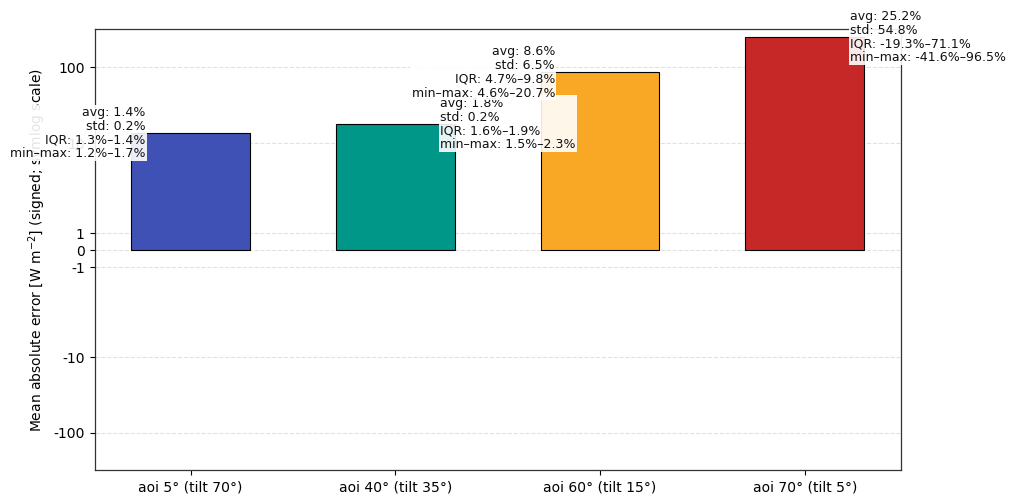

In [10]:
# -*- coding: utf-8 -*-
"""
Figure 3.5.1 — Bar chart by Platform tilt with symmetric log scale (positive & negative),
using characterisation_outdoor.csv and only rows where "absolute error [W/m2]" is present.

Per Platform tilt (ordered: 70°, 35°, 15°, 5°):
  - Bar height = mean of signed absolute error [W m^-2] (so negative remains negative).
  - y-axis = symmetric log (symlog) to make both positive and negative magnitudes readable.
  - Label (alternating left/right) shows cosine-error stats (%): avg, std, IQR(25–75), min–max.

Outputs: outputs/Figure_3_5_1_bar_symlog.png / .svg
"""

import os
import re
import functools
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# --------------------------- CONFIG ---------------------------
BASE_DIR = r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/"
INP_DIR  = os.path.join(BASE_DIR, "assets")
OUT_DIR  = os.path.join(BASE_DIR, "v_results_3_output")
CSV_FILE = os.path.join(INP_DIR,"characterisation_outdoor.csv")

FIGSIZE  = (9.6, 5.8)

# X categories (order & labels)
TILT_ORDER = [70, 35, 15, 5]
XTICK_LABELS = [
    "aoi 5° (tilt 70°)",
    "aoi 40° (tilt 35°)",
    "aoi 60° (tilt 15°)",
    "aoi 70° (tilt 5°)",
]

# Colors (distinct from Fig. 3.1.2)
BAR_COLORS = {70: "#3f51b5", 35: "#009688", 15: "#f9a825", 5: "#c62828"}  # indigo/teal/amber/crimson

# Symmetric log scale parameters
SYMLINTHRESH = 5.0   # linear range around 0 (±linthresh)
SYMLINSCALE  = 1.0   # linear stretch in the linear region
SYMBOL_BASE  = 10.0  # log base

# Label formatting & placement
LABEL_FS       = 9.0
BOX_ALPHA      = 0.90
ALT_JITTER_X   = 0.22    # horizontal offset (left/right)
LABEL_LINE_SP  = 1.08
PERC_FMT       = "{:.1f}%"
NAN_TXT        = "n/a"

os.makedirs(OUT_DIR, exist_ok=True)

# --------------------------- Helpers ---------------------------
def _norm(name: str) -> str:
    return re.sub(r"\s+", " ", str(name).strip().lower())

def _resolve_col(df_cols, wanted: str, *aliases):
    """Resolve column by normalized header; returns actual name or None."""
    norm_map = {_norm(c): c for c in df_cols}
    for w in (wanted, *aliases):
        key = _norm(w)
        if key in norm_map:
            return norm_map[key]
    return None

def _to_number(x):
    """Coerce string/number to float; handle %, commas, spaces, spreadsheet placeholders."""
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "" or s.upper() in {"#N/A", "#REF!", "#DIV/0!"}:
        return np.nan
    s = (
        s.replace("\u00A0", "")
         .replace("\u2009", "")
         .replace(" ", "")
         .replace(",", ".")
         .replace("%", "")
    )
    try:
        return float(s)
    except ValueError:
        return np.nan

# --------------------------- Tukey fences decorator (your function, modernized) ---------------------------
def timer(func):
    @functools.wraps(func)
    def _wrap(*args, **kwargs):
        return func(*args, **kwargs)
    return _wrap

def add_tukey_fences(func):
    @timer
    @functools.wraps(func)
    def describe_with_tukey_fences(df: pd.DataFrame, percentiles: List = [0.25, 0.75], *args, **kwargs):
        """
        Wrapper for pandas describe() that appends Tukey fences:
          fence_tukey_min = Q1 - 1.5*IQR
          fence_tukey_max = Q3 + 1.5*IQR
        """
        p_factors = {"25%": -1, "75%": +1}
        p_labels  = {"25%": "fence_tukey_min", "75%": "fence_tukey_max"}
        # ensure 25% and 75% are included
        for p in (0.25, 0.75):
            if p not in percentiles:
                percentiles.append(p)

        if isinstance(df, pd.DataFrame):
            desc = pd.DataFrame.describe(df, percentiles=percentiles, *args, **kwargs)
        elif isinstance(df, pd.Series):
            desc = pd.Series.describe(df, percentiles=percentiles, *args, **kwargs).to_frame().T
            desc = desc.T  # align as DataFrame index-wise
        else:
            raise TypeError("df must be a pandas DataFrame or Series.")

        # Compute fences and append as new rows (avoid deprecated .append)
        extras = {}
        for k, v in p_factors.items():
            # for each column, compute Qk ± 1.5*IQR
            row_vals = {}
            for c in desc.columns:
                q1, q3 = desc.loc["25%", c], desc.loc["75%", c]
                row_vals[c] = desc.loc[k, c] + v * 1.5 * (q3 - q1)
            extras[p_labels[k]] = row_vals

        extras_df = pd.DataFrame(extras).T
        out = pd.concat([desc, extras_df], axis=0)
        return out
    return describe_with_tukey_fences

@add_tukey_fences
def describe_with_tukey(df: pd.DataFrame, percentiles: List = [0.25, 0.75], *args, **kwargs):
    return df.describe(percentiles=percentiles, *args, **kwargs)

# --------------------------- Load & filter ---------------------------
df_raw = pd.read_csv(CSV_FILE, dtype=str)

col_aoi  = _resolve_col(df_raw.columns, "AOI", "AOI estimated", "Average of AOI estimated")
col_abs  = _resolve_col(df_raw.columns, "absolute error [W/m2]")
col_cos  = _resolve_col(df_raw.columns, "cosine error [%]")
col_tilt = _resolve_col(df_raw.columns, "Platform tilt")

if col_aoi is None or col_abs is None or col_tilt is None:
    raise KeyError(
        "Required columns not found. Needed: AOI, absolute error [W/m2], Platform tilt "
        f"\nAvailable columns: {list(df_raw.columns)}"
    )

AOI  = df_raw[col_aoi].map(_to_number)
ABS  = df_raw[col_abs].map(_to_number)
TILT = df_raw[col_tilt].map(_to_number)
COS  = df_raw[col_cos].map(_to_number) if col_cos is not None else pd.Series([np.nan] * len(df_raw))

mask = AOI.notna() & ABS.notna() & TILT.notna()
data = pd.DataFrame({"AOI": AOI[mask], "ABS": ABS[mask], "TILT": TILT[mask], "COS": COS[mask]})

# --------------------------- Aggregate per Platform tilt ---------------------------
rows = []
for tilt in TILT_ORDER:
    g = data.loc[data["TILT"] == tilt]
    if g.empty:
        rows.append({"tilt": tilt, "n": 0, "abs_mean_signed": np.nan,
                     "cos_mean": np.nan, "cos_std": np.nan,
                     "cos_q25": np.nan, "cos_q75": np.nan,
                     "cos_min": np.nan, "cos_max": np.nan})
        continue

    # Bar height = signed mean of absolute error (can be positive or negative)
    abs_mean_signed = float(g["ABS"].mean())

    # Cosine stats (drop NaNs)
    cos_ser = g["COS"].dropna()
    if cos_ser.empty:
        rows.append({"tilt": tilt, "n": int(len(g)), "abs_mean_signed": abs_mean_signed,
                     "cos_mean": np.nan, "cos_std": np.nan,
                     "cos_q25": np.nan, "cos_q75": np.nan,
                     "cos_min": np.nan, "cos_max": np.nan})
        continue

    desc = describe_with_tukey(pd.DataFrame({"cos": cos_ser}))
    rows.append({
        "tilt": tilt, "n": int(len(g)),
        "abs_mean_signed": abs_mean_signed,
        "cos_mean": float(desc.loc["mean", "cos"]),
        "cos_std":  float(desc.loc["std",  "cos"]),
        "cos_q25":  float(desc.loc["25%",  "cos"]),
        "cos_q75":  float(desc.loc["75%",  "cos"]),
        "cos_min":  float(desc.loc["min",  "cos"]),
        "cos_max":  float(desc.loc["max",  "cos"]),
    })

agg = pd.DataFrame(rows)

# --------------------------- Plot (bars on symlog y) ---------------------------
plt.rcParams.update({
    "axes.edgecolor": "#333",
    "axes.linewidth": 0.9,
    "grid.color": "#bdbdbd",
    "grid.linestyle": "--",
    "grid.alpha": 0.45,
    "axes.grid": True,
    "font.size": 10,
})

fig, ax = plt.subplots(figsize=FIGSIZE)

x = np.arange(len(TILT_ORDER))
heights = agg["abs_mean_signed"].to_numpy(float)

# Draw bars (signed heights)
bars = []
for i, tilt in enumerate(TILT_ORDER):
    color = BAR_COLORS.get(tilt, "#888")
    h = heights[i]
    bars.append(ax.bar(x[i], h, width=0.58, color=color,
                       edgecolor="black", linewidth=0.8, zorder=3))

# Symmetric log y-scale to show both positive & negative magnitudes
ax.set_yscale("symlog", linthresh=SYMLINTHRESH, linscale=SYMLINSCALE, base=SYMBOL_BASE)
ax.set_ylabel("Mean absolute error [W m$^{-2}$] (signed; symlog scale)")
ax.set_xlabel("")

# X-ticks
ax.set_xticks(x)
ax.set_xticklabels(XTICK_LABELS)

# Y-grid only (works with symlog)
ax.grid(True, axis="y"); ax.grid(False, axis="x")
ax.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))

# Symmetric y-limits with padding
if np.isfinite(heights).any():
    max_mag = np.nanmax(np.abs(heights[np.isfinite(heights)]))
    if not np.isfinite(max_mag) or max_mag == 0:
        max_mag = SYMLINTHRESH * 5
    pad = 1.25  # 25% headroom
    ymax = max_mag * pad
    ax.set_ylim(-ymax, ymax)

# --------------------------- Side labels (cosine stats) ---------------------------
def _fmt_pct(v):
    return NAN_TXT if (v is None or not np.isfinite(v)) else PERC_FMT.format(v)

# Use bar height as anchor (symlog handles sign nicely)
y0, y1 = ax.get_ylim()
for i, tilt in enumerate(TILT_ORDER):
    row = agg.iloc[i]
    h   = heights[i]
    if not np.isfinite(h):
        # anchor near mid-scale if bar is missing
        # for symlog, geometric mean of positive range then reflect
        # use small multiple of linthresh to stay in visible region
        y_anchor = SYMLINTHRESH * 2.0
        if i % 2 == 0:
            y_anchor = +y_anchor
        else:
            y_anchor = -y_anchor
    else:
        y_anchor = h

    txt = (
        f"avg: {_fmt_pct(row['cos_mean'])}\n"
        f"std: {_fmt_pct(row['cos_std'])}\n"
        f"IQR: {_fmt_pct(row['cos_q25'])}–{_fmt_pct(row['cos_q75'])}\n"
        f"min–max: {_fmt_pct(row['cos_min'])}–{_fmt_pct(row['cos_max'])}"
    )

    # Alternate left/right
    if i % 2 == 0:
        x_text, ha = x[i] - ALT_JITTER_X, "right"
    else:
        x_text, ha = x[i] + ALT_JITTER_X, "left"

    ax.text(
        x_text, y_anchor, txt,
        ha=ha, va="center", fontsize=LABEL_FS, color="#111",
        bbox=dict(facecolor="white", edgecolor="none", alpha=BOX_ALPHA, pad=0.8),
        linespacing=LABEL_LINE_SP, clip_on=False, zorder=5
    )

# No legend / title
fig.subplots_adjust(bottom=0.22, left=0.12, right=0.96, top=0.98)

# Save
out_png = os.path.join(OUT_DIR, "Figure_3_5_1_bar_symlog.png")
out_svg = os.path.join(OUT_DIR, "Figure_3_5_1_bar_symlog.svg")
fig.savefig(out_png, dpi=300)
fig.savefig(out_svg)
print(f"Saved: {out_png} and {out_svg}")

# Describe table

# aggregation

In [ ]:
import os
BASE_DIR = r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/"
INP_DIR  = os.path.join(BASE_DIR, "assets")
OUT_DIR  = os.path.join(BASE_DIR, "v_results_3_output")


# -*- coding: utf-8 -*-
"""
Figure 3.5.1 — Bar chart by Platform tilt (log y), with cosine-error stats as labels.

Input: characterisation_outdoor.csv
- Use only rows where "absolute error [W/m2]" is present (non-blank).
- Bars (x = Platform tilt groups): height = mean(|absolute error|) [W m^-2]
- Y-axis: logarithmic (values span ~10 to ~1000)
- For each bar, compute cosine-error statistics (%):
    • average, standard deviation
    • Tukey box (25% .. 75%)
    • min and max
  and show them as a side label (alternating left/right).
- X labels (left→right): 70°, 35°, 15°, 5° as:
    "aoi 5° (tilt 70°)", "aoi 40° (tilt 35°)", "aoi 60° (tilt 15°)", "aoi 70° (tilt 5°)"
"""

import os
import re
import functools
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# --------------------------- CONFIG ---------------------------
CSV_FILE = os.path.join(INP_DIR, "characterisation_outdoor.csv")
FIGSIZE  = (9.6, 5.6)

# Bar order and x-axis labels (exact strings requested)
TILT_ORDER = [70, 35, 15, 5]
XTICK_LABELS = [
    "aoi 5° (tilt 70°)",
    "aoi 40° (tilt 35°)",
    "aoi 60° (tilt 15°)",
    "aoi 70° (tilt 5°)",
]

# Colors (distinct from those used in Fig. 3.1.2)
BAR_COLORS = {
    70: "#3f51b5",  # indigo
    35: "#009688",  # teal
    15: "#f9a825",  # amber
    5:  "#c62828",  # crimson
}

# Label styling
LABEL_FS       = 8.8      # label font size
BOX_ALPHA      = 0.90
ALT_JITTER_X   = 0.22     # how far we shift labels left/right in x (data coords)
LABEL_LINE_SP  = 1.10
PERC_FMT       = "{:.1f}%"  # one decimal with %
W_FMT          = "{:.0f}"   # integer-like for W m^-2 when printed (not required on labels)

# os.makedirs(OUT_DIR, exist_ok=True)

# --------------------------- Small helpers ---------------------------
def _norm(name: str) -> str:
    return re.sub(r"\s+", " ", str(name).strip().lower())

def _resolve_col(df_cols, wanted: str, *aliases):
    """Resolve column by normalized header; returns actual column name or None."""
    norm_map = {_norm(c): c for c in df_cols}
    for w in (wanted, *aliases):
        key = _norm(w)
        if key in norm_map:
            return norm_map[key]
    return None

def _to_number(x):
    """Coerce string/number to float; handle %, spaces, commas, and spreadsheet placeholders."""
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "" or s.upper() in {"#N/A", "#REF!", "#DIV/0!"}:
        return np.nan
    s = (s.replace("\u00A0", "")
           .replace("\u2009", "")
           .replace(" ", "")
           .replace(",", ".")
           .replace("%", ""))
    try:
        return float(s)
    except ValueError:
        return np.nan

# --------------------------- Tukey fences decorator (as provided) ---------------------------
# minimal no-op timer to keep the signature compatible
def timer(func):
    @functools.wraps(func)
    def _wrap(*args, **kwargs):
        return func(*args, **kwargs)
    return _wrap
def add_tukey_fences(func):
    # DEV NOTE: kept structure, adapted for standalone usage.
    @timer
    @functools.wraps(func)
    def describe_with_tukey_fences(df: pd.DataFrame, percentiles: List = [0.25, 0.75], *args, **kwargs):
        """
        Wrapper for pandas describe() that appends Tukey fences:
          fence_tukey_min = Q1 - 1.5*IQR
          fence_tukey_max = Q3 + 1.5*IQR
        """
        p_factors: dict = {"25%": -1, "75%": +1}
        p_labels: dict  = {"25%": "fence_tukey_min", "75%": "fence_tukey_max"}
        # ensure 25% and 75% are included in percentiles
        [percentiles.append(p) for p in [0.25, 0.75] if p not in percentiles]

        if isinstance(df, pd.DataFrame):
            df_desc = pd.DataFrame.describe(df, percentiles=percentiles, *args, **kwargs)
        elif isinstance(df, pd.Series):
            df_desc = pd.Series.describe(df, percentiles=percentiles, *args, **kwargs)
        else:
            raise TypeError("df must be a pandas DataFrame or Series.")

        df_index = df_desc.index.to_list()
        for k, v in p_factors.items():
            if isinstance(df, pd.DataFrame):
                ft = [df_desc.loc[k, c] + v * 1.5 * (df_desc.loc["75%", c] - df_desc.loc["25%", c])
                      for c in df_desc.columns]
                df_desc = df_desc.append(dict(zip(df_desc.columns, ft)), ignore_index=True)
            elif isinstance(df, pd.Series):
                ft = df_desc[k] + v * 1.5 * (df_desc["75%"] - df_desc["25%"])
                df_desc = df_desc.append(pd.Series([ft]), ignore_index=True)
            df_index.append(p_labels[k])
            df_desc.index = df_index
        return df_desc
    return describe_with_tukey_fences

@add_tukey_fences
def describe_with_tukey(df: pd.DataFrame, percentiles: List = [0.25, 0.75], *args, **kwargs):
    return df.describe(percentiles=percentiles, *args, **kwargs)

# --------------------------- Load & filter ---------------------------
df_raw = pd.read_csv(CSV_FILE, dtype=str)

col_aoi  = _resolve_col(df_raw.columns, "AOI", "AOI estimated", "Average of AOI estimated")
col_abs  = _resolve_col(df_raw.columns, "absolute error [W/m2]")
col_cos  = _resolve_col(df_raw.columns, "cosine error [%]")
col_tilt = _resolve_col(df_raw.columns, "Platform tilt")

if col_aoi is None or col_abs is None or col_tilt is None:
    raise KeyError(
        "Required columns not found. Needed: AOI, absolute error [W/m2], Platform tilt "
        f"\nAvailable columns: {list(df_raw.columns)}"
    )

# Convert to numeric
AOI  = df_raw[col_aoi].map(_to_number)
ABS  = df_raw[col_abs].map(_to_number)
TILT = df_raw[col_tilt].map(_to_number)
COS  = df_raw[col_cos].map(_to_number) if col_cos is not None else pd.Series([np.nan] * len(df_raw))

# Keep only rows with absolute error present
mask = AOI.notna() & ABS.notna() & TILT.notna()
data = pd.DataFrame({
    "AOI":  AOI[mask],
    "ABS":  ABS[mask],
    "TILT": TILT[mask],
    "COS":  COS[mask] if COS is not None else np.nan,
})

# We'll use absolute magnitude of absolute error for bar height (log y requires positive heights)
data["ABS_MAG"] = data["ABS"].abs()

# --------------------------- Aggregate per Platform tilt (requested order) ---------------------------
rows = []
for tilt in TILT_ORDER:
    group = data.loc[data["TILT"] == tilt]
    if group.empty:
        rows.append({
            "tilt": tilt, "n": 0,
            "abs_mean": np.nan,
            "cos_mean": np.nan, "cos_std": np.nan,
            "cos_q25": np.nan, "cos_q75": np.nan,
            "cos_min": np.nan, "cos_max": np.nan,
            "cos_fence_min": np.nan, "cos_fence_max": np.nan,
        })
        continue
    # Bar height = mean(|ABS|) [W m^-2]
    abs_mean = float(group["ABS_MAG"].mean())

    # Cosine-error stats
    cos_ser = group["COS"].dropna()
    if cos_ser.empty:
        rows.append({
            "tilt": tilt, "n": int(len(group)),
            "abs_mean": abs_mean,
            "cos_mean": np.nan, "cos_std": np.nan,
            "cos_q25": np.nan, "cos_q75": np.nan,
            "cos_min": np.nan, "cos_max": np.nan,
            "cos_fence_min": np.nan, "cos_fence_max": np.nan,
        })
        continue

    # Describe + Tukey fences
    # Use DataFrame to keep consistent indexing with describe_with_tukey
    desc = describe_with_tukey(pd.DataFrame({"cos": cos_ser}))
    # Extract values
    cos_mean = float(desc.loc["mean",  "cos"])
    cos_std  = float(desc.loc["std",   "cos"])
    cos_q25  = float(desc.loc["25%",   "cos"])
    cos_q75  = float(desc.loc["75%",   "cos"])
    cos_min  = float(desc.loc["min",   "cos"])
    cos_max  = float(desc.loc["max",   "cos"])
    
    abs_mean = float(desc.loc["mean",  "cos"])
    abs_std  = float(desc.loc["std",   "cos"])
    abs_q25  = float(desc.loc["25%",   "cos"])
    abs_q75  = float(desc.loc["75%",   "cos"])
    abs_q5  = float(desc.loc["5%",   "cos"])
    abs_q95  = float(desc.loc["95%",   "cos"])    
    abs_min  = float(desc.loc["min",   "cos"])
    abs_max  = float(desc.loc["max",   "cos"])
    # Fences from appended rows
    # They will be at the last two indices in the appended describe
    # (labels: "fence_tukey_min", "fence_tukey_max")
    cos_fence_min = float(desc.loc["fence_tukey_min", "cos"])
    cos_fence_max = float(desc.loc["fence_tukey_max", "cos"])

    rows.append({
        "tilt": tilt, "n": int(len(group)),
        "abs_mean": abs_mean,
        "cos_mean": cos_mean, "cos_std": cos_std,
        "cos_q25": cos_q25, "cos_q75": cos_q75,
        "cos_min": cos_min, "cos_max": cos_max,
        "cos_fence_min": cos_fence_min, "cos_fence_max": cos_fence_max,
    })

agg = pd.DataFrame(rows)

C:\Users\wsfm\AppData\Local\Temp\ipykernel_25244\1426528729.py:129: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_desc = df_desc.append(dict(zip(df_desc.columns, ft)), ignore_index=True)
C:\Users\wsfm\AppData\Local\Temp\ipykernel_25244\1426528729.py:129: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_desc = df_desc.append(dict(zip(df_desc.columns, ft)), ignore_index=True)
C:\Users\wsfm\AppData\Local\Temp\ipykernel_25244\1426528729.py:129: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_desc = df_desc.append(dict(zip(df_desc.columns, ft)), ignore_index=True)
C:\Users\wsfm\AppData\Local\Temp\ipykernel_25244\1426528729.py:129: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

In [8]:
agg

,tilt,n,abs_mean,cos_mean,cos_std,cos_q25,cos_q75,cos_min,cos_max,cos_fence_min,cos_fence_max
0,70,8,13.589578,1.358958,0.154972,1.258967,1.401181,1.170852,1.678414,1.045646,1.614501
1,35,7,17.911787,1.791179,0.244687,1.624929,1.888201,1.533843,2.252843,1.230021,2.283109
2,15,6,86.202070,8.620207,6.452053,4.740283,9.803004,4.631816,20.743372,-2.853799,17.397086
3,5,7,481.552770,25.228813,54.821135,-19.308729,71.143262,-41.625168,96.481338,-154.986716,206.821249


# bar plot

In [ ]:
# --------------------------- Plot (bar chart) ---------------------------
plt.rcParams.update({
    "axes.edgecolor": "#333",
    "axes.linewidth": 0.9,
    "grid.color": "#bdbdbd",
    "grid.linestyle": "--",
    "grid.alpha": 0.45,
    "axes.grid": True,
    "font.size": 10,
})

fig, ax = plt.subplots(figsize=FIGSIZE)

# X positions and heights
x = np.arange(len(TILT_ORDER))
heights = agg["abs_mean"].to_numpy(float)

# Handle missing groups (heights NaN): set to tiny positive to show “empty” bar, or skip
# Here we set a tiny bar to keep the label placement coherent in log-scale
heights_safe = np.where(np.isfinite(heights) & (heights > 0), heights, np.nan)

bars = []
for i, tilt in enumerate(TILT_ORDER):
    h = heights_safe[i]
    color = BAR_COLORS.get(tilt, "#888")
    bar = ax.bar(x[i], h, width=0.55, color=color, edgecolor="black", linewidth=0.7, zorder=3)
    bars.append(bar)

# Logarithmic y-axis (absolute error magnitudes)
ax.set_yscale("log")
ax.set_ylabel("Mean |absolute error| [W m$^{-2}$] (log scale)")
ax.set_xlabel("")

# X tick labels (requested order and wording)
ax.set_xticks(x)
ax.set_xticklabels(XTICK_LABELS)

# Y tick format (integer-like)
ax.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))

# Y-grid only (works with log scale)
ax.grid(True, axis="y"); ax.grid(False, axis="x")

# Reasonable y-limits: auto from data with a headroom factor
if np.isfinite(heights_safe).any():
    ymin = np.nanmin(heights_safe[heights_safe > 0])
    ymax = np.nanmax(heights_safe)
    ax.set_ylim(max(ymin/1.6, 1e-2), ymax*2.0)

# --------------------------- Side labels with cosine-error stats ---------------------------
# Build per-bar multi-line label
def _fmt_pct(v):
    return "n/a" if (v is None or not np.isfinite(v)) else PERC_FMT.format(v)

for i, tilt in enumerate(TILT_ORDER):
    row = agg.iloc[i]
    h   = heights_safe[i]

    # Compose label text (all in %, one decimal)
    # Note: Showing only requested stats; Tukey fences computed but not printed unless desired.
    txt = (
        f"avg: {_fmt_pct(row['cos_mean'])}\n"
        f"std: {_fmt_pct(row['cos_std'])}\n"
        f"IQR: {_fmt_pct(row['cos_q25'])}–{_fmt_pct(row['cos_q75'])}\n"
        f"min–max: {_fmt_pct(row['cos_min'])}–{_fmt_pct(row['cos_max'])}"
    )

    # Alternate left/right placement; anchor near bar mid-height (log → use h)
    # If bar missing, anchor at geometric mean of current y-limits
    y0, y1 = ax.get_ylim()
    if np.isfinite(h) and h > 0:
        y_anchor = h
    else:
        y_anchor = (y0 * y1) ** 0.5  # geometric mean on log axis

    # Horizontal position & alignment
    if i % 2 == 0:  # even → left
        x_text = x[i] - ALT_JITTER_X
        ha = "right"
    else:           # odd → right
        x_text = x[i] + ALT_JITTER_X
        ha = "left"

    ax.text(
        x_text, y_anchor, txt,
        ha=ha, va="center", fontsize=LABEL_FS, color="#111",
        bbox=dict(facecolor="white", edgecolor="none", alpha=BOX_ALPHA, pad=0.8),
        linespacing=LABEL_LINE_SP, clip_on=False, zorder=5
    )

# No legend, no title (per instruction)
fig.subplots_adjust(bottom=0.22, left=0.12, right=0.96, top=0.98)

# Save
out_png = os.path.join(OUT_DIR, "Figure_3_5_1_bar.png")
out_svg = os.path.join(OUT_DIR, "Figure_3_5_1_bar.svg")
fig.savefig(out_png, dpi=300)
fig.savefig(out_svg)
print(f"Saved: {out_png} and {out_svg}")

# Scatter Plot

Saved: C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/v_results_3_output\Figure_3_5_1.png and C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/v_results_3_output\Figure_3_5_1.svg


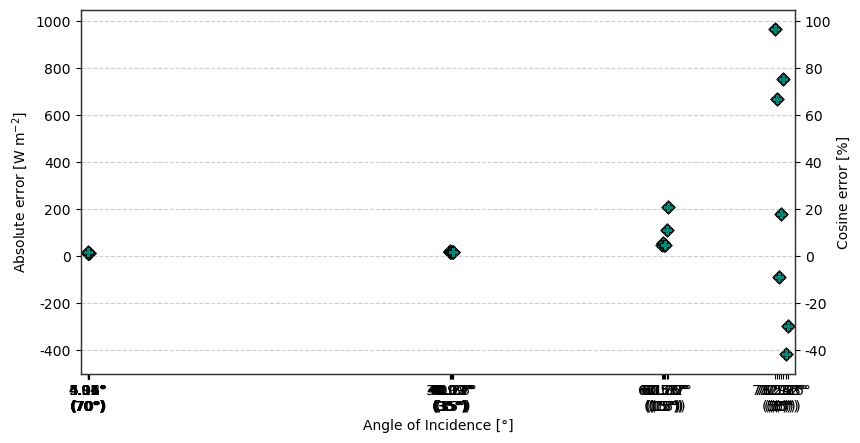

In [4]:
import os
# ----------------------- Configure your paths/files -----------------------
BASE_DIR = r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/"
INP_DIR  = os.path.join(BASE_DIR, "assets")
OUT_DIR  = os.path.join(BASE_DIR, "v_results_3_output")

# -*- coding: utf-8 -*-
"""
Figure 3.5.1 — Absolute error vs AOI (optional Cosine error on a right axis)

- Left y-axis: Absolute error [W m^-2]  (required)
- Right y-axis: Cosine error [%]        (optional → TWINX_ACTIVATE switch)
- X-axis: AOI (deg); x-tick labels show AOI on line 1 and Platform tilt on line 2
- No title; No legend; y-grid only
- Colors/markers intentionally different from Figure 3.1.2

Data source: characterisation_outdoor.csv (provided by user).
"""

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# --------------------------- CONFIG ---------------------------
TWINX_ACTIVATE = True              # toggle the right-axis (Cosine error [%])
CSV_FILE       = os.path.join(INP_DIR,"characterisation_outdoor.csv")
FIGSIZE        = (9.4, 5.2)

# Distinct palette/markers (avoid Fig 3.1.2 colors)
COLOR_ABS, MK_ABS = "#6d4c41", "D"   # deep brown, diamond
COLOR_COS, MK_COS = "#00897b", "P"   # teal, filled-plus

# --------------------------- Helpers ---------------------------
def _norm(name: str) -> str:
    return re.sub(r"\s+", " ", str(name).strip().lower())

def _resolve_col(df_cols, wanted: str, *aliases):
    """Resolve column by normalized header; returns actual column name or None."""
    norm_map = {_norm(c): c for c in df_cols}
    candidates = [wanted, *aliases]
    for w in candidates:
        key = _norm(w)
        if key in norm_map:
            return norm_map[key]
    return None

def _to_number(x):
    """Coerce string/number to float; remove %/spaces/commas if present."""
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "" or s.upper() in {"#N/A", "#REF!", "#DIV/0!"}:
        return np.nan
    s = (s.replace("\u00A0", "")
           .replace("\u2009", "")
           .replace(" ", "")
           .replace(",", ".")
           .replace("%", ""))
    try:
        return float(s)
    except ValueError:
        return np.nan

# --------------------------- Load & filter ---------------------------
# os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(CSV_FILE, dtype=str)

# Resolve required columns (using your headers)
col_aoi  = _resolve_col(df.columns, "AOI", "AOI estimated", "Average of AOI estimated")
col_abs  = _resolve_col(df.columns, "absolute error [W/m2]")
col_cos  = _resolve_col(df.columns, "cosine error [%]")   # optional
col_tilt = _resolve_col(df.columns, "Platform tilt")

if col_aoi is None or col_abs is None or col_tilt is None:
    raise KeyError(
        "Required columns not found in CSV. Needed: AOI, absolute error [W/m2], Platform tilt"
        f"\nAvailable columns: {list(df.columns)}"
    )

# Convert to numeric and filter rows where absolute error is present
AOI  = df[col_aoi].map(_to_number)
ABS  = df[col_abs].map(_to_number)
TILT = df[col_tilt].map(_to_number)

mask = AOI.notna() & ABS.notna() & TILT.notna()
AOI, ABS, TILT = AOI[mask].to_numpy(float), ABS[mask].to_numpy(float), TILT[mask].to_numpy(float)

# Cosine error (optional)
COS = None
if TWINX_ACTIVATE and col_cos is not None:
    COS_raw = df.loc[mask, col_cos].map(_to_number).to_numpy(float)
    # If cosine error column exists but all values are NaN (unlikely), disable twinx
    if np.isfinite(COS_raw).any():
        COS = COS_raw
    else:
        TWINX_ACTIVATE = False

# --------------------------- Plot ---------------------------
plt.rcParams.update({
    "axes.edgecolor": "#333",
    "axes.linewidth": 0.9,
    "grid.color": "#bdbdbd",
    "grid.linestyle": "--",
    "grid.alpha": 0.45,
    "axes.grid": True,
    "font.size": 10,
})
fig, ax = plt.subplots(figsize=FIGSIZE)

# Absolute error (left)
ax.scatter(
    AOI, ABS, s=48, marker=MK_ABS, c=COLOR_ABS,
    edgecolors="black", linewidths=0.6, zorder=3
)

# Optional Cosine error on right axis
ax2 = None
if TWINX_ACTIVATE and COS is not None:
    ax2 = ax.twinx()
    ax2.scatter(
        AOI, COS, s=44, marker=MK_COS, c=COLOR_COS,
        edgecolors="black", linewidths=0.6, alpha=0.95, zorder=3
    )
    ax2.set_ylabel("Cosine error [%]")
    ax2.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))

# Axes labels (no title, no legend)
ax.set_xlabel("Angle of Incidence [°]")
ax.set_ylabel("Absolute error [W m$^{-2}$]")
ax.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))

# Y-grid only
ax.grid(True, axis="y"); ax.grid(False, axis="x")

# Two-line x-ticks: first line AOI (2 decimals + °), second line (tilt°)
def fmt_xtick(aoi, tilt):
    return f"{aoi:.2f}°\n({int(round(tilt))}°)"

xtick_labels = [fmt_xtick(a, t) for a, t in zip(AOI, TILT)]
ax.set_xticks(AOI)          # keep original measurement order
ax.set_xticklabels(xtick_labels)

# Margins & limits
xpad = 0.01 * (AOI.max() - AOI.min() if AOI.max() > AOI.min() else 1.0)
ax.set_xlim(AOI.min() - xpad, AOI.max() + xpad)

abs_min, abs_max = float(np.nanmin(ABS)), float(np.nanmax(ABS))
ypad = 0.06 * (abs_max - abs_min if abs_max > abs_min else 1.0)
ax.set_ylim(abs_min - ypad, abs_max + ypad)

if ax2 is not None:
    cos_min, cos_max = float(np.nanmin(COS)), float(np.nanmax(COS))
    ypad2 = 0.06 * (cos_max - cos_min if cos_max > cos_min else 1.0)
    ax2.set_ylim(cos_min - ypad2, cos_max + ypad2)

# Layout: extra room for two-line ticks
fig.subplots_adjust(bottom=0.28, left=0.12, right=0.88, top=0.98)

# Save
out_png = os.path.join(OUT_DIR, "Figure_3_5_1.png")
out_svg = os.path.join(OUT_DIR, "Figure_3_5_1.svg")
fig.savefig(out_png, dpi=300)
fig.savefig(out_svg)
print(f"Saved: {out_png} and {out_svg}")